In [1]:
from scipy.stats import spearmanr
from collections import defaultdict
#from tqdm import tqdm
from utils import get_datasets, get_correlations
import numpy as np
from matplotlib import pyplot as plt
from nudging.dataset import Pennycook1

In [2]:
sim_datasets = get_datasets(n=5000)

In [3]:
sub_results = get_correlations(sim_datasets)

In [4]:
def plot_sub_cates(results):
    plt.figure(dpi=120)
    for model_name, model_res in results.items():
        plt.scatter(model_res["all"], model_res["individual"], label=model_name)
        print(model_name, spearmanr(model_res["all"], model_res["individual"]))
    plt.xlabel("subgroup CATE")
    plt.ylabel("individual CATE")
    plt.legend()
    plt.show()

In [5]:
from sklearn.linear_model import LinearRegression
import seaborn as sns

def plot_sub_individual(results, bounds=(0.0, 0.25)):
    a, b = None, None
    data = {}
    for model_name, model_res in results.items():
        x_sub = np.array(model_res["all"])
        y_ind = np.array(model_res["individual"])
        x_idx = np.logical_and(x_sub >= bounds[0], x_sub <= bounds[1])
        x_sub = x_sub[x_idx]
        y_ind = y_ind[x_idx]

        if a is None:
            model = LinearRegression().fit(x_sub.reshape(-1, 1), y_ind)
            a = model.coef_[0]
            b = model.intercept_
        bound_mid = np.mean(bounds)
        y_ind_adj = y_ind + (bound_mid-x_sub)*b
        data[model_name] = y_ind_adj
        #plt.hist(y_ind_adj, label=model_name)
    #plt.legend()
    #plt.show()
    sns.displot(data, kind="kde")

def plot_shift_individual(model_res, delta=0.2):
    x_sub = np.array(model_res["all"])
    y_ind = np.array(model_res["individual"])
    model = LinearRegression().fit(x_sub.reshape(-1, 1), y_ind)
    a = model.coef_[0]
    b = model.intercept_
    data = {}
    for bound_start in np.arange(-0.2, 1, step=delta/2):
        bound_end = bound_start+delta
        bound_mid = (bound_start+bound_end)/2
        x_idx = np.logical_and(x_sub >= bound_start, x_sub <= bound_end)
        data[str(bound_mid)] = y_ind[x_idx] + (bound_mid-x_sub[x_idx])*b
    sns.displot(data, kind="kde")
    plt.show()
    y = np.array([np.mean(x) for x in data.values()])
    x = np.array([float(x) for x in list(data)]).astype(float)
    plt.plot(x, y)
    plt.plot(x, x)
    plt.show()

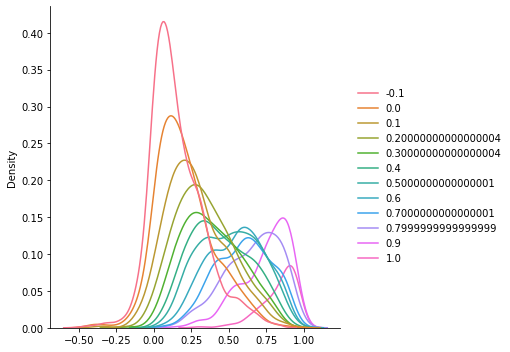

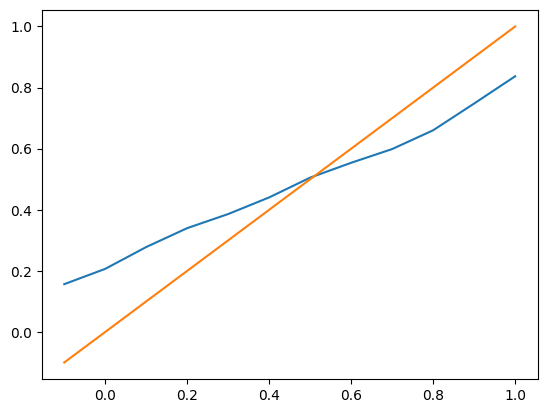

In [7]:
plot_shift_individual(sub_results["t-learner (ARD)"])

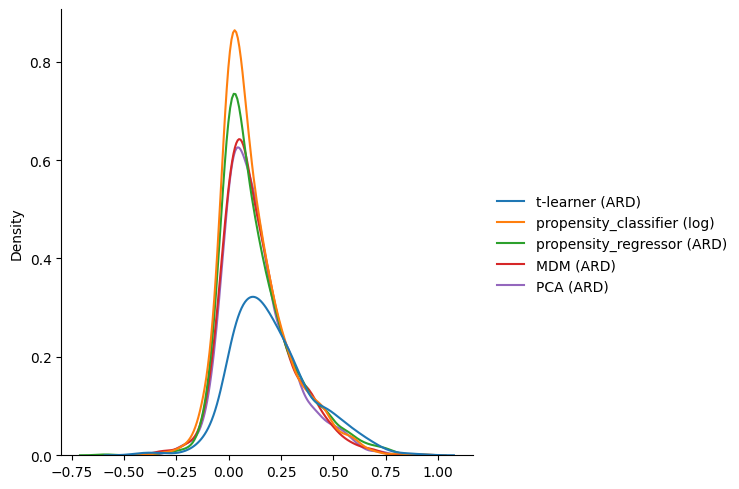

In [8]:
plot_sub_individual(sub_results, bounds=(-0.1, 0.1))

t-learner (ARD) SpearmanrResult(correlation=0.7597774381693322, pvalue=0.0)
propensity_classifier (log) SpearmanrResult(correlation=0.6985006922920276, pvalue=0.0)
propensity_regressor (ARD) SpearmanrResult(correlation=0.6936827584630552, pvalue=0.0)
MDM (ARD) SpearmanrResult(correlation=0.7366084174003367, pvalue=0.0)
PCA (ARD) SpearmanrResult(correlation=0.724680879163235, pvalue=0.0)


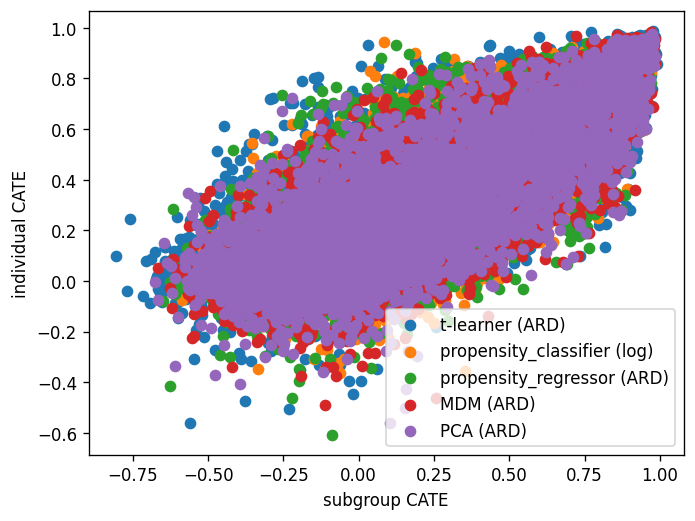

In [9]:
plot_sub_cates(sub_results)

In [17]:
from nudging.dataset import Pennycook1, Pennycook2, Balaban, Lieberoth, Vandenbroele, Hotard
from nudging.model import MDMModel, ProbModel, BiRegressor, PCAModel
from sklearn.linear_model import ARDRegression, LogisticRegression
from nudging.partition import compute_partition_correlation, KSplitPartitioner, KMeansPartitioner

In [12]:
all_data = {
    "penny1": Pennycook1.from_file("data"),
    "penny2": Pennycook2.from_file("data"),
    "balaban": Balaban.from_file("data"),
    "hotard": Hotard.from_file("data"),
    "lieberoth": Lieberoth.from_file("data"),
    "broele": Vandenbroele.from_file("data"),
}

/home/qubix/Documents/shared_work/nudging/nudging-code/nudging/dataset/real.py:141: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:, col_new] = cat_values


In [18]:
dataset = Pennycook1.from_file("data")
models = {
    "mdm": MDMModel(ARDRegression()),
    "prob_log": ProbModel(LogisticRegression()),
    "prob_bay": ProbModel(ARDRegression()),
    "t-learner": BiRegressor(ARDRegression()),
    "pca": PCAModel(ARDRegression()),
}
for dataset_name, dataset in all_data.items():
    print(f"------ {dataset_name} ------")
    for model_name, model in models.items():
        print(model_name, compute_partition_correlation(model, dataset, KSplitPartitioner, KMeansPartitioner))

------ penny1 ------
mdm {'ksplit': 0.3174510828332237, 'kmeans': 0.37156466565488494, 'all': 0.33739055930044526}
prob_log {'ksplit': 0.18984924490237082, 'kmeans': 0.016391055269442782, 'all': 0.16094399310564228}
prob_bay {'ksplit': 0.12278652116916444, 'kmeans': -0.10811185349216942, 'all': 0.08598016337617523}
t-learner {'ksplit': 0.31328462369394544, 'kmeans': 0.26640345778433894, 'all': 0.30214942651903764}
pca {'ksplit': 0.07894012963974606, 'kmeans': 0.28452228035548316, 'all': 0.11107348491864243}
------ penny2 ------
mdm {'ksplit': -0.4227125300660591, 'kmeans': -0.2067673560947405, 'all': -0.36982539464414765}
prob_log {'ksplit': -0.29929739243163617, 'kmeans': -0.2872229411028092, 'all': -0.29247253327731626}
prob_bay {'ksplit': -0.002675232826444036, 'kmeans': -0.06345444482578434, 'all': -0.012069626560401944}
t-learner {'ksplit': 0.14797672006640145, 'kmeans': 0.3493315606194708, 'all': 0.18941541358270056}
pca {'ksplit': -0.09634847905480846, 'kmeans': -0.0074701395394

/home/qubix/.pyenv/versions/3.10.4/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qubix/.pyenv/versions/3.10.4/lib/python3.10/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/home/qubix/.pyenv/versions/3.10.4/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qubix/.pyenv/versions/3.10.4/lib/python3.10/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/home/qubix/.pyenv/versions/3.10.4/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qubix/.pyenv/versions/3.10.4/lib/python3.10/site-packages/numpy/core/_methods.py:182: RuntimeWarning: inva

pca {'ksplit': 0.15234184532320486, 'kmeans': 0.3726936573435887, 'all': 0.2458046731457507}
